## 0. Initial setup

In [61]:
import dateutil
import numpy as np
import pandas as pd
import simplejson as json
import wordcloud

In [19]:
with open('secrets.txt', 'r') as f:
    env = json.load(f)
print('Loaded env vars')

Loaded env vars


## 1. Quick tokenization and sentiment

In [ ]:
from nltk.tokenize import TweetTokenizer
tweet_tokenizer = TweetTokenizer()

tokenized_train_tweets = [(tweet_tokenizer.tokenize(t),l) for t,l in train_tweets]

print(len(tokenized_train_tweets))
print(tokenized_train_tweets[0])

In [ ]:
import nltk
nltk.download('twitter_samples')

In [ ]:
from nltk.corpus import twitter_samples

In [ ]:
pos_tweets = [(t, 'pos') for t in twitter_samples.strings('positive_tweets.json')]
neg_tweets = [(t, 'neg') for t in twitter_samples.strings('negative_tweets.json')]
print(len(pos_tweets))
print(len(neg_tweets))

In [ ]:
import random

random.shuffle(pos_tweets)
random.shuffle(neg_tweets)

In [ ]:
train_pos_tweets = pos_tweets[:4500]
test_pos_tweets = pos_tweets[4500:]

train_neg_tweets = neg_tweets[:4500]
test_neg_tweets = neg_tweets[4500:]

train_tweets = train_pos_tweets + train_neg_tweets
test_tweets = test_pos_tweets + test_neg_tweets

print(len(train_tweets))
print(len(test_tweets))

In [ ]:
from nltk.sentiment import SentimentAnalyzer

sentim_analyzer = SentimentAnalyzer()

In [ ]:
all_words = sentim_analyzer.all_words(tokenized_train_tweets)
print(len(all_words))
print(all_words[0:10])

In [ ]:
from nltk.sentiment.util import extract_unigram_feats

unigram_feats = sentim_analyzer.unigram_word_feats(all_words, min_freq=4)
print(len(unigram_feats))
print(unigram_feats[0:20])
sentim_analyzer.add_feat_extractor(extract_unigram_feats, unigrams=unigram_feats)

In [ ]:
training_set = sentim_analyzer.apply_features(train_tweets)
test_set = sentim_analyzer.apply_features(test_tweets)

In [ ]:
from nltk.classify import NaiveBayesClassifier

trainer = NaiveBayesClassifier.train
classifier = sentim_analyzer.train(trainer, training_set)
for key, value in sorted(sentim_analyzer.evaluate(test_set).items()):
    print('{0}: {1}'.format(key, value))

In [ ]:
# t = 'RT @RedditBTC: Russia plans $10 Billion Bitcoin investment... so it begins. https://t.co/vSSeeZWG9s'
t = "i don't get bitcoin"
classifier.classify(sentim_analyzer.extract_features(t))

In [ ]:
# import twython
import nltk.sentiment.util
from nltk.classify import NaiveBayesClassifier

trainer = NaiveBayesClassifier.train

# ans = nltk.sentiment.util.demo_tweets(trainer, output='output.txt')

### Using textblob for quick polarity

In [ ]:
from textblob import TextBlob

In [ ]:
for t in tweets[0:50]:
    print('Tweet:\n' + t)
    blob = TextBlob(t)
    sents = blob.sentences
    if len(sents) >= 1:
        sent = sents[0]
        print(sent.sentiment)
    print('')

## 2. Retrieving tweets with tweepy

In [ ]:
import tweepy

In [ ]:
# env vars are set at the top of the file.

auth = tweepy.OAuthHandler(env[tw_oauth_key], env[tw_oauth_secret])
auth.set_access_token(env[tw_token_key], env[tw_token_secret])

api = tweepy.API(auth)

In [ ]:
bitcoin_tweets = api.search('bitcoin', lang='en', count=100)
print(len(bitcoin_tweets))
print([t.text for t in bitcoin_tweets[0:5]])

In [ ]:
cursor = tweepy.Cursor(api.search, q='bitcoin', lang='en', count=100, tweet_mode='extended')

In [ ]:
tlist = []

for page in cursor.pages(15):
    tlist.extend(page)

print(len(tlist))

In [ ]:
tweets = [t.full_text for t in tlist]
print(len(tweets))

## 3. Retrieving tweets from ElasticSearch

In [101]:
import elasticsearch
import elasticsearch_dsl


In [17]:
# Create a model for tweets stored in the elasticsearch instance:
class ESTweet(elasticsearch_dsl.Document):
    created_at = elasticsearch_dsl.Date()
    stored_at = elasticsearch_dsl.Date()
    full_text = elasticsearch_dsl.Text(analyzer='snowball')
    subjectivity = elasticsearch_dsl.Float()
    polarity = elasticsearch_dsl.Float()
    author_id = elasticsearch_dsl.Integer()
    author_followers = elasticsearch_dsl.Integer()

    class Index:
        name = 'tweets'


In [108]:
import math

math.ceil(50500 / 10000)
min(5,6)

5

In [113]:
# env vars are loaded at the beginning of the file.
es_client = elasticsearch.Elasticsearch(hosts=[env['es_endpoint']])

def get_tweets_from_elasticsearch(max_tweets=50000):
    max_page_size = 10000
    tweet_hits = []
    for page in range(math.ceil(max_tweets / max_page_size)):
        start = page * max_page_size
        end = min((page + 1) * max_page_size, max_tweets)
        print(f'retrieving page {page} from {start} to {end}')
        search = elasticsearch_dsl.Search(index='tweets').using(es_client)\
                    .query('match_all')\
                    .sort({'created_at': {'order': 'desc'}})[start:end]
        search.execute()

        for hit in search:
            tweet_hits.append(hit)
    return tweet_hits


def scan_all_tweets_from_elasticsearch(max_tweets=5000):
    tweet_hits = []
    search = elasticsearch_dsl.Search(index='tweets').using(es_client).query('match_all')
    search.execute()

    for hit in search.scan():
        tweet_hits.append(hit)
        if len(tweet_hits) >= max_tweets:
            break
    return tweet_hits


In [103]:
def hitlist_to_dataframe(hit_list):
    """
    Transform tweet hitlist (from Elasticsearch) to a dataframe
    """
    id_strs = []
    created_ats = []
    full_texts = []
    ndropped = 0
    for hit in hit_list:
        id_str = str(hit.meta.id)
        
        if 'created_at' in hit and 'full_text' in hit:
            id_strs.append(id_str)
            created_ats.append(dateutil.parser.parse(hit['created_at']))
            full_texts.append(hit['full_text'])
        else:
            ndropped += 1
    df = pd.DataFrame({'id_str': id_strs, 'created_at': created_ats, 'full_text': full_texts})
    print('ndropped = {}'.format(ndropped))
    return df


In [ ]:
df_tweets = hitlist_to_dataframe(tweet_hits)
tweet_hits = None # ready for garbage collection

df_tweets.head(10)

In [ ]:
df_tweets.set_index(df_tweets['created_at'])
df_tweets = df_tweets.drop(columns=['id_str', 'created_at'])
df_tweets.head()

## 4. NLP on tweets using Sentiment Analysis Dataset (SAD)

In [5]:
import dill
import matplotlib.pyplot as plt
import nltk.tokenize
import sklearn.feature_extraction.text
import sklearn.model_selection
import sklearn.naive_bayes
import sklearn.pipeline
from sklearn import base

### 4.1. Load the dataset

In [ ]:
df_sad = pd.read_csv('Sentiment Analysis Dataset.csv', error_bad_lines=False)
print(df_sad.shape)

In [ ]:
df_sad.head()

In [ ]:
labels_sad = df_sad['Sentiment']
labels_sad.head()

In [ ]:
df_sad = df_sad.drop(columns=['ItemID', 'Sentiment', 'SentimentSource'])
df_sad.head()

### 4.2. A first pass at cleaning

In [38]:
# Custom nltk transformer for cleaning and tokenizing tweets:

class TwitterPreprocessor(base.BaseEstimator, base.TransformerMixin):
    def __init__(self, column='SentimentText'):
        self.column = column
        self.tw_tokenizer = nltk.tokenize.TweetTokenizer(
            strip_handles=True, reduce_len=True, preserve_case=False)
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
#         ans = X.copy()
#         ans[self.column] = ans[self.column].apply(self._prepare_tweet)
        ans = X[self.column].apply(self._prepare_tweet)
        return ans
        
    def _prepare_tweet(self, tweet):
        tokens = self.tw_tokenizer.tokenize(tweet)
        clean_tweet = ' '.join([token for token in tokens
                                if len(token) > 1 and not token.startswith('http')])
        return clean_tweet


In [ ]:
tw_preprocessor = TwitterPreprocessor()
df2 = tw_preprocessor.transform(df_sad)
df2.head()

In [ ]:
# min_df is chosen by off-hand estimate. we should search over it.
# try bigrams ASAP
tfidf_vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(
    ngram_range=(1,1), min_df=100
)

In [ ]:
raise Exception('Caution: this is slow! Comment this exception if you are sure you want to continue')
df3 = tfidf_vectorizer.fit_transform(df2['SentimentText'])
print(df3.shape)
print(type(df3))

In [ ]:
tfidf_vectorizer.vocabulary_

In [ ]:
# Reduce the serialized file size
tfidf_vectorizer.stop_words_ = None
tfidf_vectorizer.vocabulary_ = None

### 4.3. Train Multinomial Naive Bayes

In [ ]:
mnb_estimator = sklearn.naive_bayes.MultinomialNB()

# TODO:
# param_grid = {
#     'tfidf_vectorizer__min_df': linspace(0,)
# }

grid_search_cv = sklearn.model_selection.GridSearchCV(
    mnb_estimator, param_grid={'alpha': [0.1, 0.5, 1.0, 10.0]}, cv=5
)

In [ ]:
grid_search_cv.fit(df3, labels_sad)

In [ ]:
best_estimator = grid_search_cv.best_estimator_
best_estimator

In [ ]:
dill.dump(tw_preprocessor, open('tw_preprocessor.dill', 'wb'))
dill.dump(tfidf_vectorizer, open('tfidf_vectorizer.dill', 'wb'))
dill.dump(best_estimator, open('best_mnb_estimator.dill', 'wb'))

In [ ]:
pipe = sklearn.pipeline.Pipeline([
    ('tw_preprocessor', tw_preprocessor),
    ('tfidf_vectorizer', tfidf_vectorizer),
    ('estimator', estimator)
])
pipe

In [ ]:
example = pd.DataFrame({'SentimentText': ['bitcoin is awesome and it will grow this year']})
print(example)

In [ ]:
pipe.predict(example)

## 5. Wordclouds

In [75]:
def build_word_cloud(df, column_name='full_text', **kwargs):
    """
    Prepare and show a wordcloud.
    """
    corpus = ''
    for text in df[column_name]:
        corpus += text
        corpus += ' '

    cloud = wordcloud.WordCloud(
        width=800, height=450, random_state=21, max_font_size=110, background_color='white', **kwargs
    ).generate(corpus)

    plt.figure(figsize=(8, 5))
    plt.imshow(cloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()


In [ ]:
build_word_cloud(df2)

## 6. Load pre-trained models

In [14]:
import dill
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

In [2]:
tfidf_vectorizer: TfidfVectorizer = dill.load(open('tfidf_vectorizer.dill', 'rb'))
best_estimator: MultinomialNB = dill.load(open('best_mnb_estimator.dill', 'rb'))


/Users/gdiazc/Google Drive/Data Incubator 2019/workspace/sentiment-dashboard/venv/lib/python3.7/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.19.1 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/gdiazc/Google Drive/Data Incubator 2019/workspace/sentiment-dashboard/venv/lib/python3.7/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.19.1 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/gdiazc/Google Drive/Data Incubator 2019/workspace/sentiment-dashboard/venv/lib/python3.7/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator MultinomialNB from version 0.19.1 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [39]:
tw_preprocessor = TwitterPreprocessor(column='full_text')

In [40]:
pipe = sklearn.pipeline.Pipeline([
    ('tw_preprocessor', tw_preprocessor),
    ('tfidf_vectorizer', tfidf_vectorizer),
    ('estimator', best_estimator)
])
pipe

Pipeline(memory=None,
     steps=[('tw_preprocessor', TwitterPreprocessor(column='full_text')), ('tfidf_vectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=100,
 ...      vocabulary=None)), ('estimator', MultinomialNB(alpha=10.0, class_prior=None, fit_prior=True))])

In [42]:
example = pd.DataFrame({'full_text': ['bitcoin is awesome and it will grow this year']})
print(example)
pipe.predict(example)

                                       full_text
0  bitcoin is awesome and it will grow this year


array([1])

### 6.2. Get tweets from elasticsearch

In [114]:
tweet_hits = scan_all_tweets_from_elasticsearch(max_tweets=50000)

In [115]:
len(tweet_hits)

50000

In [116]:
df_tweets = hitlist_to_dataframe(tweet_hits)

ndropped = 7


In [118]:
tweet_hits = None

In [117]:
df_tweets.head()

,id_str,created_at,full_text
0,5CxggmgB8uluafRYNLrQ,2019-01-25 00:18:36,"RT TechREDEF ""Despite Bitcoin's Dive, a Former..."
1,8SxqgmgB8uluafRYd7px,2019-01-25 00:30:22,#crypto mkt cap winners last 2 hours\n\n$BTC $...
2,_ixrgmgB8uluafRYZbrm,2019-01-25 00:31:15,Bitcoin Vip Mining - an investment project dea...
3,DSxsgmgB8uluafRYqbu8,2019-01-25 00:32:36,Litecoin v Bitcoin Looking Good 😉👍\n\n🎙Podcast...
4,5ixggmgB8uluafRYNrq0,2019-01-25 00:18:24,"RT @iamjosephyoung: On CNBC ETF Edge, VanEck C..."


In [119]:
df_tweets['full_text_clean'] = tw_preprocessor.transform(df_tweets)

In [120]:
df_tweets['ih_sentiment'] = pipe.predict(df_tweets)

In [121]:
df_tweets.head()

,id_str,created_at,full_text,full_text_clean,ih_sentiment
0,5CxggmgB8uluafRYNLrQ,2019-01-25 00:18:36,"RT TechREDEF ""Despite Bitcoin's Dive, a Former...",rt techredef despite bitcoin's dive former sov...,1
1,8SxqgmgB8uluafRYd7px,2019-01-25 00:30:22,#crypto mkt cap winners last 2 hours\n\n$BTC $...,#crypto mkt cap winners last hours btc waves r...,1
2,_ixrgmgB8uluafRYZbrm,2019-01-25 00:31:15,Bitcoin Vip Mining - an investment project dea...,bitcoin vip mining an investment project deali...,1
3,DSxsgmgB8uluafRYqbu8,2019-01-25 00:32:36,Litecoin v Bitcoin Looking Good 😉👍\n\n🎙Podcast...,litecoin bitcoin looking good podcast #bitcoin...,1
4,5ixggmgB8uluafRYNrq0,2019-01-25 00:18:24,"RT @iamjosephyoung: On CNBC ETF Edge, VanEck C...",rt on cnbc etf edge vaneck ceo jan van eck sai...,0


In [122]:
df_tweets['ih_sentiment'].describe()

count    49993.000000
mean         0.690497
std          0.462294
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: ih_sentiment, dtype: float64

### 4.3. Wordcloud

In [123]:
from wordcloud import WordCloud

In [124]:
stopwords=['https', 'co', 'rt', 'bitcoin', 'btc', 'the', 'for', 'and',
           'is', 'of', 'at', 'to', 'it', 'that', 'are', 'in']

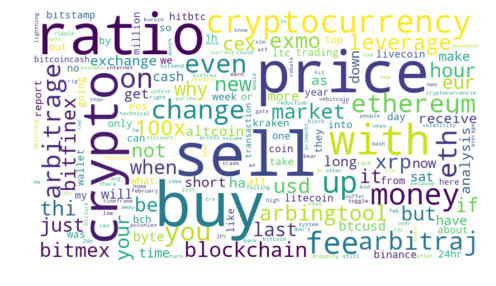

In [125]:
build_word_cloud(df_tweets[df_tweets['ih_sentiment'] == 0],
                 column_name='full_text_clean', stopwords=stopwords, collocations=False)

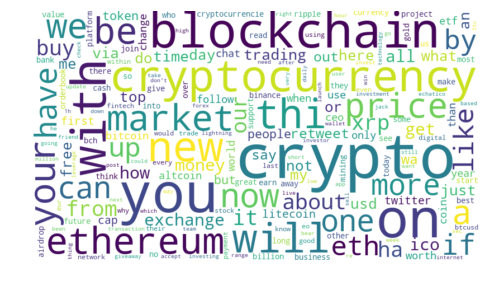

In [126]:
build_word_cloud(df_tweets[df_tweets['ih_sentiment'] == 1],
                 column_name='full_text_clean', stopwords=stopwords, collocations=False)

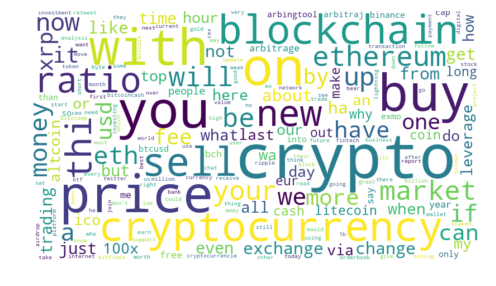

In [127]:
build_word_cloud(df_tweets,
                 column_name='full_text_clean', stopwords=stopwords, collocations=False)

In [128]:
from collections import Counter
vocab = Counter()

for tweet in df_tweets['full_text_clean']:
    for token in tweet.split():
        vocab[token] += 1

print(len(vocab))

45289


In [137]:
pos_vocab = Counter()

for tweet in df_tweets[df_tweets['ih_sentiment'] == 1]['full_text_clean']:
    for token in tweet.split():
        pos_vocab[token] += 1

print(len(pos_vocab))

34054


In [134]:
neg_vocab = Counter()

for tweet in df_tweets[df_tweets['ih_sentiment'] == 0]['full_text_clean']:
    for token in tweet.split():
        neg_vocab[token] += 1

print(len(neg_vocab))

23091


In [131]:
i = 0
for key, val in vocab.items():
    print(f'{key}: {val}')
    i += 1
    if i > 10:
        break

rt: 20653
techredef: 2
despite: 128
bitcoin's: 597
dive: 26
former: 65
soviet: 2
republic: 8
is: 13661
still: 789
betting: 88


In [135]:
total_vocab = 0
for key, val in vocab.items():
    total_vocab += val
print(total_vocab)

945151


In [138]:
pos_total_vocab = 0
for key, val in pos_vocab.items():
    pos_total_vocab += val
print(pos_total_vocab)

618923


In [139]:
neg_total_vocab = 0
for key, val in neg_vocab.items():
    neg_total_vocab += val
print(neg_total_vocab)

326228


In [142]:
pos_term_importance = []

for key, val in pos_vocab.items():
    importance = (val / pos_total_vocab) / (vocab[key] / total_vocab)
    pos_term_importance.append((importance, key))

pos_term_importance = sorted(pos_term_importance, key=lambda item: -item[0])
print(pos_term_importance[:10])

[(1.5270897995388766, 'vip'), (1.5270897995388766, '#bitcoinpodcast'), (1.5270897995388766, '#cryptocurrencypodcast'), (1.5270897995388766, '#podcast'), (1.5270897995388766, 'huffington'), (1.5270897995388766, 'alexander'), (1.5270897995388766, 'pub'), (1.5270897995388766, 'estima'), (1.5270897995388766, 'dyor'), (1.5270897995388766, 'becaus')]


In [143]:
neg_term_importance = []

for key, val in neg_vocab.items():
    importance = (val / neg_total_vocab) / (vocab[key] / total_vocab)
    neg_term_importance.append((importance, key))

neg_term_importance = sorted(neg_term_importance, key=lambda item: -item[0])
print(neg_term_importance[:10])

[(2.897209926799662, '1.18'), (2.897209926799662, '#optionstrading'), (2.897209926799662, '30-01-'), (2.897209926799662, 'byte'), (2.897209926799662, '1.11'), (2.897209926799662, '-0.45'), (2.897209926799662, '#binancesignals'), (2.897209926799662, '#opec'), (2.897209926799662, '#ecb'), (2.897209926799662, '#mifidi8')]


In [147]:
pos_term_importance[:100]

[(1.5270897995388766, 'vip'),
 (1.5270897995388766, '#bitcoinpodcast'),
 (1.5270897995388766, '#cryptocurrencypodcast'),
 (1.5270897995388766, '#podcast'),
 (1.5270897995388766, 'huffington'),
 (1.5270897995388766, 'alexander'),
 (1.5270897995388766, 'pub'),
 (1.5270897995388766, 'estima'),
 (1.5270897995388766, 'dyor'),
 (1.5270897995388766, 'becaus'),
 (1.5270897995388766, '430'),
 (1.5270897995388766, 'anniversary'),
 (1.5270897995388766, 'aviv'),
 (1.5270897995388766, 'expand'),
 (1.5270897995388766, 'newest'),
 (1.5270897995388766, '#interdax'),
 (1.5270897995388766, 'strain'),
 (1.5270897995388766, 'empowr'),
 (1.5270897995388766, 'dedicated'),
 (1.5270897995388766, 'debut'),
 (1.5270897995388766, 'camps'),
 (1.5270897995388766, 'mar'),
 (1.5270897995388766, 'derived'),
 (1.5270897995388766, 'favorable'),
 (1.5270897995388766, 'turkey'),
 (1.5270897995388766, 'overstock'),
 (1.5270897995388766, '#blockonomics'),
 (1.5270897995388766, 'bck'),
 (1.5270897995388766, 'step-by-step'),

In [148]:
neg_term_importance[:100]

[(2.897209926799662, '1.18'),
 (2.897209926799662, '#optionstrading'),
 (2.897209926799662, '30-01-'),
 (2.897209926799662, 'byte'),
 (2.897209926799662, '1.11'),
 (2.897209926799662, '-0.45'),
 (2.897209926799662, '#binancesignals'),
 (2.897209926799662, '#opec'),
 (2.897209926799662, '#ecb'),
 (2.897209926799662, '#mifidi8'),
 (2.897209926799662, '#federalreserve'),
 (2.897209926799662, 'bitcoinaverage'),
 (2.897209926799662, '1.37'),
 (2.897209926799662, 'equivalence'),
 (2.897209926799662, '0.85'),
 (2.897209926799662, '1.91'),
 (2.897209926799662, '-5.7'),
 (2.897209926799662, 'cambia'),
 (2.897209926799662, 'tus'),
 (2.897209926799662, 'rublos'),
 (2.897209926799662, 'haz'),
 (2.897209926799662, 'clic'),
 (2.897209926799662, '10:45'),
 (2.897209926799662, '1.63'),
 (2.897209926799662, 'appro'),
 (2.897209926799662, 'logs'),
 (2.897209926799662, 'crashed'),
 (2.897209926799662, '1.79'),
 (2.897209926799662, '9.8'),
 (2.897209926799662, 'no-fee'),
 (2.897209926799662, 'intermediary

## 5. Bokeh

In [ ]:
import bokeh
from bokeh.plotting import figure, show
from bokeh.io import output_notebook

In [ ]:
output_notebook()

In [ ]:
df_tweets.head()

In [ ]:
def get_tb_polarity(tweet):
    blob = textblob.TextBlob(tweet)
    sents = blob.sentences
    if len(sents) >= 1:
        sent = sents[0]
        return float(sent.sentiment.polarity)
    else:
        return np.NaN


In [ ]:
df_tweets['tb_polarity'] = df_tweets['full_text'].apply(get_tb_polarity)
df_tweets.head()

In [ ]:
df_tweets.dtypes

In [ ]:
df_tweets['tb_polarity'].describe()

In [ ]:
s_polarity = pd.Series(data=df_tweets['tb_polarity'].values, index=df_tweets['created_at'].values)
s_polarity = s_polarity.sort_index()
len(s_polarity)

In [ ]:
s_polarity = s_polarity.resample('H').mean()
print(len(s_polarity))
s_polarity.head()

In [ ]:
import bokeh.models

p = figure(
    plot_width=800, plot_height=450,
    tools="",
    x_axis_label='time', y_axis_label='polarity',
    x_axis_type='datetime'
)

# Format background colors:
low_box = bokeh.models.BoxAnnotation(top=0, fill_alpha=0.1, fill_color='red')
high_box = bokeh.models.BoxAnnotation(bottom=0, fill_alpha=0.1, fill_color='green')
p.add_layout(low_box)
p.add_layout(high_box)

# Format gridlines:
p.xgrid[0].grid_line_color=None
p.ygrid[0].grid_line_alpha=0.5

# Format view range:
p.y_range = bokeh.models.Range1d(-1.0, 1.0)

# Prepare data:
cd_source = bokeh.models.ColumnDataSource({'timestamp': s_polarity.index, 'polarity': s_polarity})

p.line('timestamp', 'polarity', source=cd_source, line_width=2)
p.circle('timestamp', 'polarity', source=cd_source, fill_color="white", size=2)

p.add_tools(bokeh.models.HoverTool(
    tooltips=[
        ('time', '@timestamp{%F %H:%M}'),
        ("polarity", "@polarity{+0.00}")
    ],
    formatters={'timestamp': 'datetime', 'polarity': 'numeral'},
    mode='vline'
))


In [ ]:
show(p)